**Group Members:**

* Chandana Vangapalli (ID: 233323)
* Yizhou Yu (ID: 236819)
* Akpany Aubin Benjamin Ebby (ID: 232836 )
* Bangyi Wu (ID: 183398)


**Objective:**

The primary objective of our project is to apply sentiment analysis to the US airline industry twitter data to understand the trends in customer perceptions about some of the biggest airline companies in the USA. Further, we will also investigate what factors drive positive and negative sentiments and how this would impact the overall industry.  


**Data:**

We will use airline industry tweets for our analysis. Alternatively, we may use twitter datasets sourced from Kaggle.


In [1]:
%load_ext rpy2.ipython
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tree import *
import matplotlib.pyplot as plt

In [3]:
%%R
library(dplyr)
library(reticulate)
library(ggplot2)
library(rtweet)

# U.S. Airline Twitter

**Load the Data**

In [4]:
nltk.download("stopwords") # Load StopWords
tweets_dataset = pd.read_csv("data/US_Airline_Tweets.csv") # Load Data

# %Rpush tweets_dataset

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
%%R

tweets_df <- read.csv("data/US_Airline_Tweets.csv", encoding = "UTF-8", header=TRUE, stringsAsFactors=FALSE)

**Data Exploration**

_Data Columns:_

In [6]:
%%R
tweets_df %>% colnames() # Columns

 [1] "tweet_id"                     "airline_sentiment"           
 [3] "airline_sentiment_confidence" "negativereason"              
 [5] "negativereason_confidence"    "airline"                     
 [7] "airline_sentiment_gold"       "name"                        
 [9] "negativereason_gold"          "retweet_count"               
[11] "text"                         "tweet_coord"                 
[13] "tweet_created"                "tweet_location"              
[15] "user_timezone"               


_Data Dimention / Shape:_

In [7]:
%%R
tweets_df %>% dim() # Shape / Dimension

[1] 14640    15


_Data Summary:_

In [8]:
%%R
tweets_df %>% summary() # Data Summary

    tweet_id         airline_sentiment  airline_sentiment_confidence
 Min.   :5.676e+17   Length:14640       Min.   :0.3350              
 1st Qu.:5.686e+17   Class :character   1st Qu.:0.6923              
 Median :5.695e+17   Mode  :character   Median :1.0000              
 Mean   :5.692e+17                      Mean   :0.9002              
 3rd Qu.:5.699e+17                      3rd Qu.:1.0000              
 Max.   :5.703e+17                      Max.   :1.0000              
                                                                    
 negativereason     negativereason_confidence   airline         
 Length:14640       Min.   :0.000             Length:14640      
 Class :character   1st Qu.:0.361             Class :character  
 Mode  :character   Median :0.671             Mode  :character  
                    Mean   :0.638                               
                    3rd Qu.:1.000                               
                    Max.   :1.000                         

_positive, negative, and neutral tweets shapes:_

In [9]:
positive_tweets = tweets_dataset['airline_sentiment'].str.contains("positive")
negative_tweets = tweets_dataset['airline_sentiment'].str.contains("negative")
neutral_tweets = tweets_dataset['airline_sentiment'].str.contains("neutral")


print(f'positive tweets shape: {positive_tweets.shape}')
print(f'negative tweets shape: {negative_tweets.shape}')
print(f'neutral tweets shape: {neutral_tweets.shape}')

positive tweets shape: (14640,)
negative tweets shape: (14640,)
neutral tweets shape: (14640,)


_airlines tweets shapes:_

In [14]:
American = tweets_dataset['airline'].str.contains("American")
Delta = tweets_dataset['airline'].str.contains("Delta")
Southwest = tweets_dataset['airline'].str.contains("Southwest")
United = tweets_dataset['airline'].str.contains("United")
VAmerica = tweets_dataset['airline'].str.contains("Virgin America")
USair = tweets_dataset['airline'].str.contains("US Airways")

print(f'American Tweets Shape: {American.shape}')
print(f'Delta Tweets Shape: {Delta.shape}')
print(f'Southwest Tweets Shape: {Southwest.shape}')
print(f'United Tweets Shape: {United.shape}')
print(f'VAmerica Tweets Shape: {VAmerica.shape}')
print(f'USair Tweets Shape: {USair.shape}')

American Tweets Shape: (14640,)
Delta Tweets Shape: (14640,)
Southwest Tweets Shape: (14640,)
United Tweets Shape: (14640,)
VAmerica Tweets Shape: (14640,)
USair Tweets Shape: (14640,)


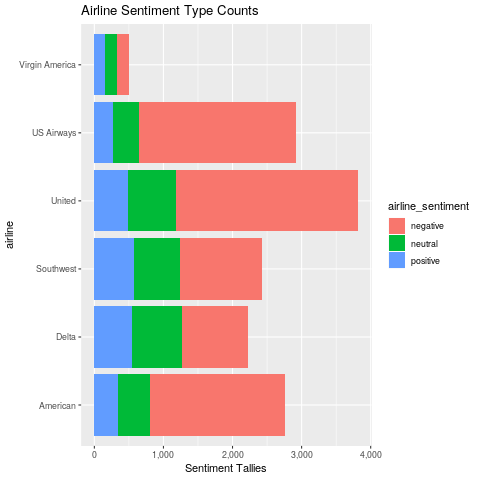

In [11]:
%%R
tweets_sentiment_groups_df <- tweets_df %>%
    group_by(airline_sentiment) %>%
    rowwise() %>%
    mutate(SENTIMENT_COUNT = n()) %>%
    select(airline, airline_sentiment, SENTIMENT_COUNT)

# tweets_sentiment_groups_df %>% head()
    
ggplot(tweets_sentiment_groups_df, aes(x = airline, y = SENTIMENT_COUNT, fill=airline_sentiment)) +
  geom_bar(stat="identity") +
  coord_flip() +
  scale_y_continuous(name="Sentiment Tallies", labels = scales::comma) +
  ggtitle("Airline Sentiment Type Counts")

**Train Test Split**

In [15]:
tweets_dataset_train, tweets_dataset_test = train_test_split(
    tweets_dataset, test_size=0.2
)

print(f'tweets_dataset_train tweets shape: {tweets_dataset_train.shape}')
print(f'tweets_dataset_test tweets shape: {tweets_dataset_test.shape}')

tweets_dataset_train tweets shape: (11712, 15)
tweets_dataset_test tweets shape: (2928, 15)
